In [ ]:
# # Reducing the dataset to 15,000 images 
# # Taking a random 150 immages from both folders and their corresponding variations 
# import numpy as np
# import pandas as pd
# import shutil
# import os
# import random
# from sklearn.model_selection import train_test_split

# clear_path = '/kaggle/input/art-images-clear-and-distorted/Art_Dataset_Clear/'
# foreign_images = os.listdir(os.path.join(clear_path, 'Foreign'))
# indian_images = os.listdir(os.path.join(clear_path, 'Indian'))

# # Getting a random 150 images  
# foreign_images_subset = random.sample(foreign_images, 150)
# indian_images_subset = random.sample(indian_images, 150)

# # Splitting into training and testing sets (80% training, 20% testing)
# # Important to note that these just contain the name of the files not the actaul image data 
# foreign_train, foreign_test = train_test_split(foreign_images_subset, test_size=0.2, random_state=45)
# indian_train, indian_test = train_test_split(indian_images_subset, test_size=0.2, random_state=45)

# train_images = []
# test_images = []

# train_images = foreign_train + indian_train
# test_images = foreign_test + indian_test

# # Matching up the image to its distorted versions 
# distorted_path = '/kaggle/input/art-images-clear-and-distorted/Art_Dataset_Distorted/'
# distorted_images = os.listdir(os.path.join(distorted_path, 'Distorted'))

# def get_distorted_variations(image_name, distorted_folder):
#     base_name = os.path.splitext(image_name)[0]
#     variations = [f for f in os.listdir(os.path.join(distorted_path, 'Distorted')) if f.startswith(base_name)]
#     return variations

In [7]:
# # Fetching distorted variations for training and testing
# distorted_train = []
# for image in train_images:
#     distorted_train.extend(get_distorted_variations(image, distorted_path))

# distorted_test = []
# for image in test_images:
#     distorted_test.extend(get_distorted_variations(image, distorted_path))

In [9]:
# # Saving the images
# output_dir = '/kaggle/working/images_subset'
# train_dir = os.path.join(output_dir, 'train')
# test_dir = os.path.join(output_dir, 'test')
# distorted_train_dir = os.path.join(output_dir, 'distorted_train')
# distorted_test_dir = os.path.join(output_dir, 'distorted_test')

# os.makedirs(train_dir, exist_ok=True)
# os.makedirs(test_dir, exist_ok=True)
# os.makedirs(distorted_train_dir, exist_ok=True)
# os.makedirs(distorted_test_dir, exist_ok=True)

In [10]:
# # Copy training images to the train directory
# for img in train_images:
#     if "F" in img:
#         shutil.copy(os.path.join(clear_path, 'Foreign', img), train_dir)
#     else:
#         shutil.copy(os.path.join(clear_path, 'Indian', img), train_dir)
        
# for img in test_images:
#     if "F" in img:
#         shutil.copy(os.path.join(clear_path, 'Foreign', img), test_dir)
#     else:
#         shutil.copy(os.path.join(clear_path, 'Indian', img), test_dir)
        
# for img in distorted_train:
#     shutil.copy(os.path.join(distorted_path, 'Distorted', img), distorted_train_dir)

# for img in distorted_test:
#     shutil.copy(os.path.join(distorted_path, 'Distorted', img), distorted_test_dir)

In [22]:
# # Create a zip file
# shutil.make_archive('/kaggle/working/images_subset', 'zip', '/kaggle/working', 'images_subset')

'/kaggle/working/images_subset.zip'

# Preprocess and Load Data

In [ ]:
import os
import tensorflow as tf

distorted_train_dir = '/kaggle/input/images-15000/images_subset/distorted_train/'
clear_train_dir = '/kaggle/input/images-15000/images_subset/train/'
distorted_test_dir = '/kaggle/input/images-15000/images_subset/distorted_test/'
clear_test_dir = '/kaggle/input/images-15000/images_subset/test/'

def preprocess_image(image_path, target_size=(256, 256)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, target_size)
    image = image / 255.0  # Normalize
    return image


import os
import tensorflow as tf

distorted_train_dir = '/kaggle/input/images-15000/images_subset/distorted_train/'
clear_train_dir = '/kaggle/input/images-15000/images_subset/train/'
distorted_test_dir = '/kaggle/input/images-15000/images_subset/distorted_test/'
clear_test_dir = '/kaggle/input/images-15000/images_subset/test/'

def preprocess_image(image_path, target_size=(256, 256)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, target_size)
    image = image / 255.0  # Normalize
    return image

# Using np arrays takes up too much RAM
# Converting np array to tf.data.Dataset will be more efficent 
def load_image_dataset(distorted_dir, clear_dir, target_size=(256, 256)):
    distorted_paths = sorted([os.path.join(distorted_dir, fname) for fname in os.listdir(distorted_dir)])
    clear_paths = sorted([os.path.join(clear_dir, fname) for fname in os.listdir(clear_dir)])

    clear_paths = [path for path in clear_paths for _ in range(50)]  # Repeat clear images 50 times
    
    dataset = tf.data.Dataset.from_tensor_slices((distorted_paths, clear_paths))
    dataset = dataset.map(lambda distorted, clear: (preprocess_image(distorted, target_size), 
                                                    preprocess_image(clear, target_size)), num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

In [5]:
# Load training and testing datasets
train = load_image_dataset(distorted_train_dir, clear_train_dir)
test = load_image_dataset(distorted_test_dir, clear_test_dir)
train = train.batch(32)
test = test.batch(32)

In [ ]:
import matplotlib.pyplot as plt

def visualize_dataset(dataset, num_samples=3):
    """Visualize paired distorted and clear images."""
    for distorted, clear in dataset.take(num_samples):
        distorted_image = distorted.numpy()
        clear_image = clear.numpy()

        plt.figure(figsize=(8, 4))
        
        plt.subplot(1, 2, 1)
        plt.title("Distorted Image")
        plt.imshow(distorted_image)
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.title("Clear Image")
        plt.imshow(clear_image)
        plt.axis('off')
        
        plt.show()

print("Checking training dataset...")
visualize_dataset(train.unbatch(), num_samples=3)

# CNN Model

In [4]:
# Buidling the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import layers, models

def build_cnn_model(input_shape=(256, 256, 3)):
    model = Sequential()
    # Extracts features from the input images by applying filters 
    # We do multiple filters to extract more details 
    model.add(Conv2D(64, (3,3), 1, activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling2D()) # reduces the spatial size

    model.add(layers.Conv2D(128, (3, 3), 1,activation='relu', padding='same'))
    model.add(layers.MaxPooling2D())

    model.add(layers.Conv2D(256, (3, 3), 1, activation='relu', padding='same'))
    model.add(layers.MaxPooling2D())
    
    # reconstructs the image back to its original 
    model.add(layers.Conv2DTranspose(256, (3, 3), 1, activation='relu', padding='same'))
    model.add(layers.UpSampling2D((2, 2)))
    
    model.add(layers.Conv2DTranspose(128, (3, 3), 1, activation='relu', padding='same'))
    model.add(layers.UpSampling2D((2, 2)))

    model.add(layers.Conv2DTranspose(64, (3, 3), 1, activation='relu', padding='same'))
    model.add(layers.UpSampling2D((2, 2)))
    
    # output layer
    # 3 filters because RGB values 
    model.add(layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same'))
    
    return model

In [ ]:
# we are using adam because its efficient and has little memory requirement
input_shape = (256, 256, 3)
model = build_cnn_model(input_shape)
model.compile('adam', loss='mean_squared_error', metrics=['accuracy'])
model.summary()

In [ ]:
# Training the data 
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, epochs=10, batch_size=32)

# Building the U-NET Model

In [6]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

def build_unet_model(input_shape=(256, 256, 3)):
    inputs = Input(shape=input_shape)

    # Encoder (downsampling path)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck with more filters
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)

    # Decoder (upsampling path)
    u5 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = concatenate([u5, c3])  
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(u5)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c2])  
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c1])  
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    outputs = Conv2D(3, (1, 1), activation='tanh')(c7)

    model = Model(inputs, outputs)
    return model

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model

vgg = VGG19(weights='imagenet', include_top=False)
vgg_model = Model(inputs=vgg.input, outputs=vgg.get_layer('block3_conv3').output)
vgg_model.trainable = False

def compute_perceptual(y_true, y_pred):
    y_true_vgg = tf.keras.applications.vgg19.preprocess_input(y_true)
    y_pred_vgg = tf.keras.applications.vgg19.preprocess_input(y_pred)

    y_true_vgg = vgg_model(y_true_vgg)
    y_pred_vgg = vgg_model(y_pred_vgg)

    perceptual_loss = tf.reduce_mean(tf.square(y_true_vgg - y_pred_vgg))
    return perceptual_loss

def compute_gradients(y_true, y_pred):
    dy_true, dx_true = tf.image.image_gradients(y_true)
    dy_pred, dx_pred = tf.image.image_gradients(y_pred)

    gradient_loss = tf.reduce_mean(tf.abs(dy_pred - dy_true) + tf.abs(dx_pred - dx_true), axis=-1)
    return gradient_loss

def combined_loss(y_true, y_pred):
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    perceptual_loss = compute_perceptual(y_true, y_pred)
    gradient_loss = compute_gradients(y_true, y_pred)

    total_loss = mse_loss + 0.2 * perceptual_loss + 0.2 * gradient_loss
    return total_loss

In [7]:
learning_rate = 1e-5
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
input_shape = (256, 256, 3)

unet_model = build_unet_model(input_shape)
unet_model.compile(optimizer=optimizer, loss=combined_loss, metrics=['accuracy'])
unet_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 64, 64,    │    524,544 │ conv2d_7[0][0]    │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 512)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 64, 64,    │  1,179,904 │ concatenate[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_8[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 128, 128,  │    131,200 │ conv2d_9[0][0]  

 Total params: 7,697,475 (29.36 MB)

 Trainable params: 7,697,475 (29.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Training the U-Net model
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

hist = unet_model.fit(train, epochs=50, batch_size=32, validation_data=test, callbacks=[tensorboard_callback, early_stopping])

In [ ]:
# Training the U-Net model
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

# Train the model
hist = unet_model.fit(train, epochs=10, batch_size=32, validation_data=test, callbacks=[tensorboard_callback, early_stopping])

Epoch 1/15


2024-11-08 03:16:52.515808: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng18{k11=2} for conv (f32[128,128,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,128,128]{3,2,1,0}, f32[32,128,128,128]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-11-08 03:16:52.567013: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.051312843s
Trying algorithm eng18{k11=2} for conv (f32[128,128,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,128,128]{3,2,1,0}, f32[32,128,128,128]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_q

375/375 ━━━━━━━━━━━━━━━━━━━━ 518s 1s/step - accuracy: 0.5892 - loss: 0.0980
Epoch 2/15
 64/375 ━━━━━━━━━━━━━━━━━━━━ 5:33 1s/step - accuracy: 0.7043 - loss: 0.0902

# Predictions and Evaluations

I0000 00:00:1731035727.875863      96 service.cc:145] XLA service 0x7969700050b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731035727.875924      96 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731035727.875929      96 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


I0000 00:00:1731035734.036019      96 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


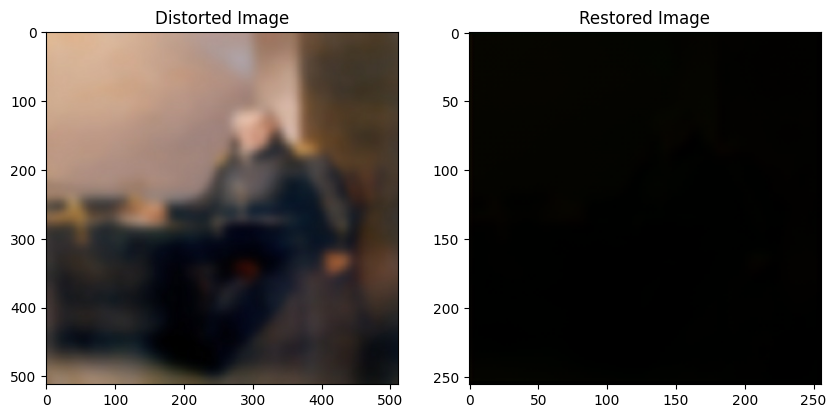

In [8]:
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import os

random_image_name = random.choice(os.listdir(distorted_test_dir))
random_image_path = os.path.join(distorted_test_dir, random_image_name)

# Extract the corresponding clear image
identifier = random_image_name.split('_')[0].strip()
clear_image_name = f"{identifier}.jpg"
clear_image_path = os.path.join(clear_test_dir, clear_image_name)

# Preprocess the distorted image for prediction
input_image = preprocess_image(random_image_path)
input_image = tf.expand_dims(input_image, axis=0)  # Add batch dimension
predicted_image = unet_model.predict(input_image)
predicted_image = tf.squeeze(predicted_image, axis=0)  # Remove batch dimension

# Load the original distorted and clear images
original_distorted_image = tf.image.decode_jpeg(tf.io.read_file(random_image_path))
original_clear_image = tf.image.decode_jpeg(tf.io.read_file(clear_image_path))

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Distorted Image")
plt.imshow(original_distorted_image)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Predicted Image")
plt.imshow(predicted_image)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Clear Image")
plt.imshow(original_clear_image)
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Visulizations and Predictions
unet_model.evaluate(test)

In [ ]:
# Save the model and weights so we can later deploy them
unet_model.save('/kaggle/working/unet_model.h5')
unet_model.save('/kaggle/working/unet_model.keras') # Tensowflow format

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('/kaggle/input/unet_model_checkpoint/tensorflow2/default/1/unet_model checkpoint.h5', compile=False)

In [ ]:
hist = unet_model.fit(train, 
                      epochs=13,
                      batch_size=32, 
                      validation_data=test)